In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch

ckpt_path = "D:/programs/VoiceMark/train/Log/spt_base/WatermarkTrainer_00001000.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("🔎 Checkpoint type:", type(ckpt))

if isinstance(ckpt, dict):
    print("✅ Keys in checkpoint:")
    for i, k in enumerate(ckpt.keys()):
        print(f"  {i+1}. {k}")
        if i >= 20:  # 最多只打印前 20 个 key
            break
else:
    print("⚠️ Checkpoint is not a dict, type:", type(ckpt))

🔎 Checkpoint type: <class 'dict'>
✅ Keys in checkpoint:
  1. embedder
  2. detectors
  3. optim_embedder
  4. optim_detectors
  5. scheduler_embedder
  6. scheduler_detectors
  7. best_dev_loss


In [13]:
from example.watermark import embed_watermark, decode_watermark

In [14]:
from example.audio import load_audio, play_audio, plot_waveform_and_specgram

waveform, sr = load_audio("../audios/1.wav", target_sr=16000)
print(waveform.shape, sr)

torch.Size([1, 80000]) 16000


D:\programs\VoiceMark\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [15]:
play_audio(waveform, sr)

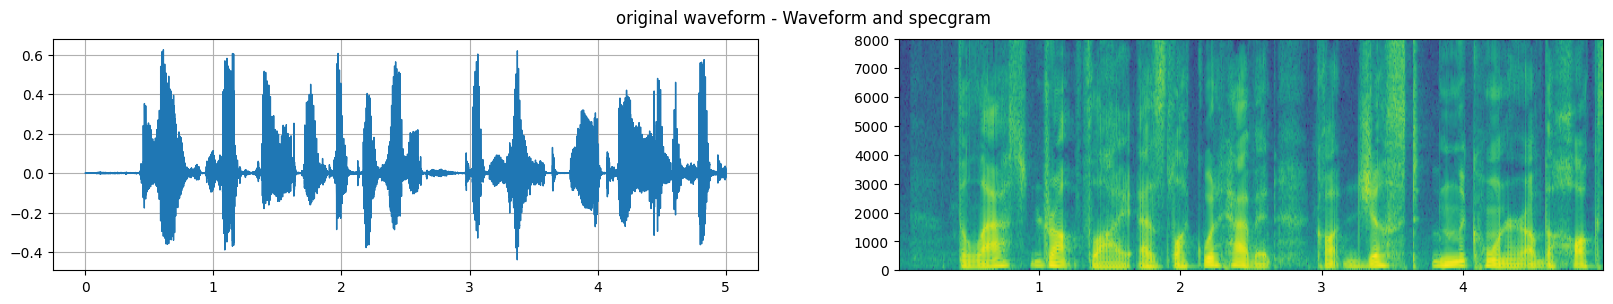

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

plot_waveform_and_specgram(waveform, sr, "original waveform")

In [17]:
watermarked_audio = embed_watermark(waveform, sample_rate=sr, message="1111111100000000")

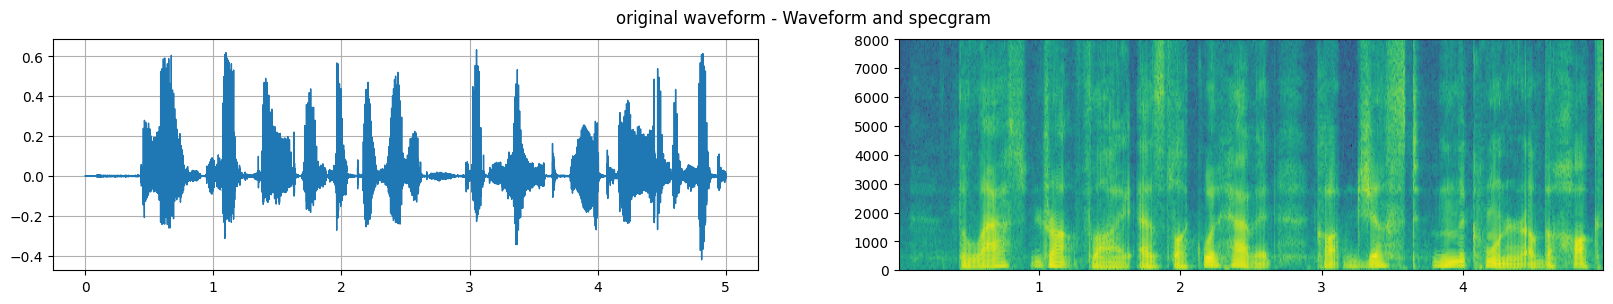

In [18]:
plot_waveform_and_specgram(watermarked_audio, sr, "original waveform")

In [19]:
result, message = decode_watermark(watermarked_audio.squeeze(0), sr)
print(result, message)

0.4041500985622406 0000011100011100


In [21]:
from example.attacks import AudioEffects as af

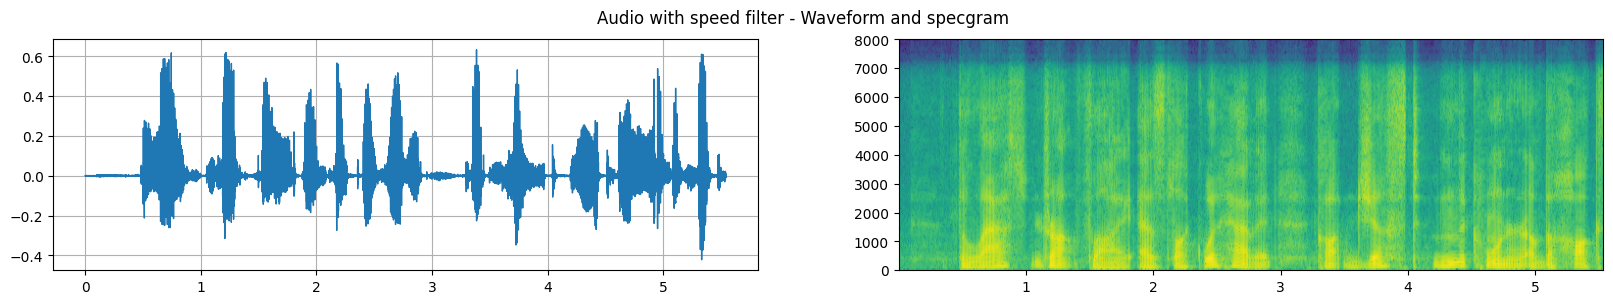

In [22]:
speed = af.speed(watermarked_audio, sample_rate=sr, speed_range=(0.9, 1.1))
plot_waveform_and_specgram(speed, sample_rate=sr, title="Audio with speed filter")
play_audio(speed, sr)

In [23]:
result, message = decode_watermark(speed.squeeze(0), sr)
print(f"Detection Result with Speed Filter: {result, message}")

Detection Result with Speed Filter: (0.359878271818161, '0000011110100100')
